MultiRAT analysis code
================
Joanes Grandjean

![rat art](../assets/img/rat_art.png)

# Foreword

This is a jupyter notebook which contains all the code for reproducing my
analysis. The code is meant to be followed step-wise. 

If re-using some of the scripts, please follow citations guidelines for
the software used. I’ve provided the links to the software wherever
possible. See also the [license](../LICENSE.md) for this software.


In [1]:
# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/meta_data_20210622.tsv'

In [2]:
import os
import pandas as pd
import numpy as np

df = pd.read_csv(df_path, sep='\t')

In [3]:
tsnr_map_path = os.path.join(analysis_folder, 'scratch', 'snr', 'tsnr', 'pre')
tsnr_map = os.listdir(tsnr_map_path)

roiL = 520  # left barrel field cortex
roiR = 521  # right barrel field cortex

In [4]:
# create empty tSNR column
df["tsnr.S1"] = np.nan

In [5]:
# read the tSNR file output from RABIES and put them in the correct rows
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=int(i.split('_')[7].split('-')[1])
    ses=int(i.split('_')[8].split('-')[1])
    df.loc[(df['rat.sub'] == sub) & (
        df['rat.ses'] == ses), ['tsnr.S1']]=np.double(tsnr_mean)

In [6]:
# let's do the same for subcortical ROIs
roiL = 731  # Striatum-L
roiR = 732  # Striatum-R

df["tsnr.str"] = np.nan
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=int(i.split('_')[7].split('-')[1])
    ses=int(i.split('_')[8].split('-')[1])
    df.loc[(df['rat.sub'] == sub) & (
        df['rat.ses'] == ses), ['tsnr.str']]=np.double(tsnr_mean)

In [7]:
# then we extract the mean framewise displacement
MFW_map_path = os.path.join(analysis_folder, 'scratch', 'motion', 'FD')
MFW_map = os.listdir(MFW_map_path)

df["MFW"] = np.nan
for i in MFW_map:
    MFW_list = pd.read_csv(os.path.join(MFW_map_path, i),
                            delim_whitespace=False)
    MFW_mean = np.mean(MFW_list['Mean'])
    sub=int(i.split('_')[0].split('-')[1])
    ses=int(i.split('_')[1].split('-')[1])
    df.loc[(df['rat.sub'] == sub) & (
        df['rat.ses'] == ses), ['MFW']]=np.double(MFW_mean)


In [8]:
df.to_csv(df_path, sep='\t', index=False)

In [9]:
#remove excluded scans
df_exclude = df.loc[(df['exclude'] != 'yes')]

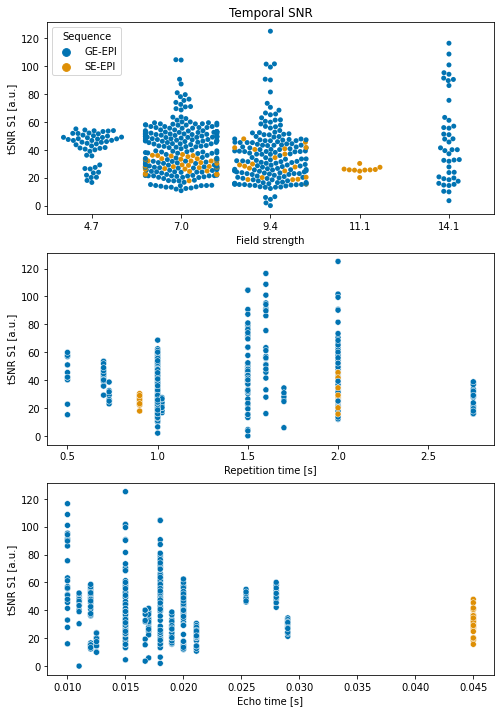

In [10]:
# plot S1 tSNR as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8, 12))

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="MRI.field.strength",
                    y="tsnr.S1", hue="func.sequence",ax=axes[0])
ax2 = sns.scatterplot(data=df_exclude, x="func.TR",
                    y="tsnr.S1", hue="func.sequence",ax=axes[1])
ax3 = sns.scatterplot(data=df_exclude, x="func.TE",
                    y="tsnr.S1", hue="func.sequence",ax=axes[2])


ax1.set(xlabel='Field strength', ylabel='tSNR S1 [a.u.]', title='Temporal SNR')
ax1.get_legend().set_title('Sequence')

ax2.set(xlabel='Repetition time [s]', ylabel='tSNR S1 [a.u.]')
ax2.get_legend().remove()

ax3.set(xlabel='Echo time [s]', ylabel='tSNR S1 [a.u.]')
ax3.get_legend().remove()

correlation between tSNR in cortex and striatum
0.8944358498127106


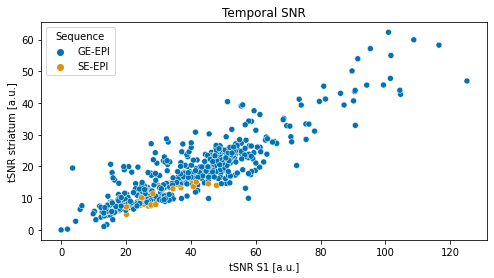

In [11]:
# does tSNR in the cortex correlate to tSNR in the striatum?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between tSNR in cortex and striatum')
print(df_exclude[['tsnr.S1','tsnr.str']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="tsnr.str", hue="func.sequence")

ax1.set(xlabel='tSNR S1 [a.u.]', ylabel='tSNR striatum [a.u.]', title='Temporal SNR')
ax1.get_legend().set_title('Sequence')

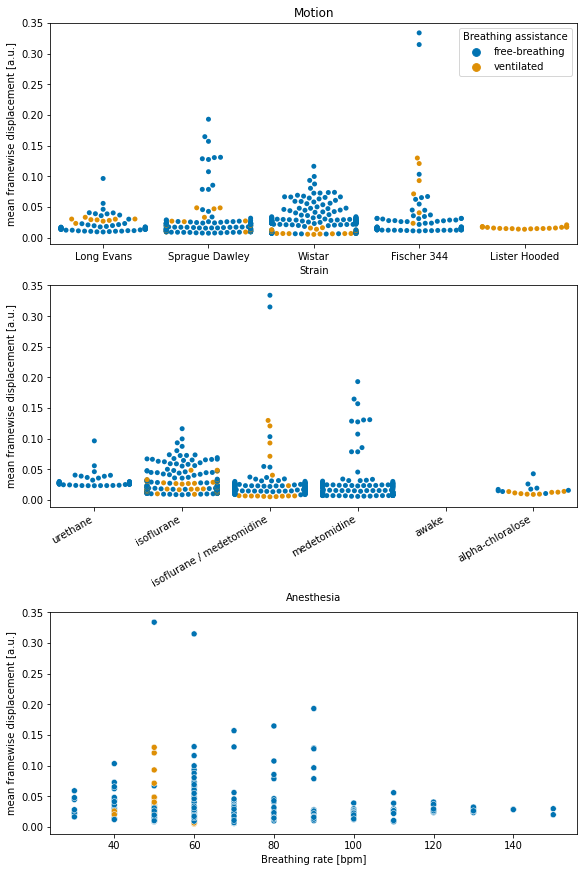

In [12]:
# plot mean framewise displacement as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8, 12),constrained_layout=True)

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="rat.strain",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[0])
ax2 = sns.swarmplot(data=df_exclude, x="anesthesia.maintenance",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[1])
ax3 = sns.scatterplot(data=df_exclude, x="anesthesia.breathing.rate",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[2])


ax1.set(xlabel='Strain', ylabel='mean framewise displacement [a.u.]', title='Motion')
ax1.get_legend().set_title('Breathing assistance')

ax2.set(xlabel='Anesthesia', ylabel='mean framewise displacement [a.u.]')
ax2.get_legend().remove()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')

ax3.set(xlabel='Breathing rate [bpm]', ylabel='mean framewise displacement [a.u.]')
ax3.get_legend().remove()

In [13]:
# testing the impact of acquisition parameters on tSNR
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

df_exclude.columns=df_exclude.columns.str.replace('[\.]', '')

print('testing for the effect of field strength')
m01 = ols('tsnrS1 ~ MFW+ MRIfieldstrength + funcsequence + funcTR + funcTE', data=df_exclude).fit()
m02 = ols('tsnrS1 ~ MFW+funcsequence + funcTR + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('mean framwise displacement')
m02 = ols('tsnrS1 ~ funcsequence+MRIfieldstrength + funcTR + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of sequence')
m02 = ols('tsnrS1 ~ MFW+MRIfieldstrength + funcTR + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of TR')
m02 = ols('tsnrS1 ~ MFW+MRIfieldstrength + funcsequence + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of TE')
m02 = ols('tsnrS1 ~ MFW+MRIfieldstrength + funcsequence + funcTR', data=df_exclude).fit()
print(anova_lm(m02, m01))


testing for the effect of field strength
   df_resid            ssr  df_diff   ss_diff         F    Pr(>F)
0     537.0  182773.707780      0.0       NaN       NaN       NaN
1     536.0  182771.742675      1.0  1.965105  0.005763  0.939516

mean framwise displacement
   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     537.0  183864.947346      0.0          NaN       NaN       NaN
1     536.0  182771.742675      1.0  1093.204671  3.205953  0.073935

testing for the effect of sequence
   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     537.0  185815.214883      0.0          NaN       NaN       NaN
1     536.0  182771.742675      1.0  3043.472208  8.925346  0.002941

testing for the effect of TR
   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     537.0  185370.960740      0.0          NaN       NaN       NaN
1     536.0  182771.742675      1.0  2599.218065  7.622518  0.005962

testing for the effect of TE
   df_resid     